In [1]:
import os
from dotenv import load_dotenv
from datetime import datetime

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

/Users/ips/Documents/trail/AI Agents/aiagent/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

retriever = vectorstore.as_retriever()

from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..  
If the document has words or meanings related to the question, mark it as relevant.  
Give a simple 'yes' or 'no' answer to show if the document is relevant or not."""
    
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)



In [5]:
my_retrieval_grader = grade_prompt | structured_llm_grader
question = "what is ai agent?"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[2].page_content

print(my_retrieval_grader.invoke({"document":doc_txt,"question": question}))

binary_score='yes'


In [6]:
question="who is sunny?"
print(my_retrieval_grader.invoke({"document":doc_txt,"question": question}))

binary_score='no'


In [7]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

rag_chain = prompt | llm

question="what is a AI agent?"

# Run
generation = rag_chain.invoke({"context": docs, "question": question})

generation

AIMessage(content='An AI agent, particularly in an LLM-powered autonomous system, uses the LLM as its core "brain." It is complemented by key components like planning, memory, and tool use. The agent can break down tasks, reflect on past actions, and use external APIs for information.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-025b7cf7-5da4-4e09-accf-abd8a0988b9f-0', usage_metadata={'input_tokens': 1981, 'output_tokens': 59, 'total_tokens': 2040, 'input_token_details': {'cache_read': 0}})

In [8]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader checking if an LLM generation is grounded in or supported by a set of retrieved facts.  
Give a simple 'yes' or 'no' answer. 'Yes' means the generation is grounded in or supported by a set of retrieved the facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucinations_grader = hallucination_prompt | structured_llm_grader

print(hallucinations_grader.invoke({"documents": docs, "generation": generation}))

binary_score='yes'


In [9]:
### Answer Grader
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
print(answer_grader.invoke({"question": question, "generation": generation}))

binary_score='yes'


In [10]:
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.  
You are given both a question and a document.  
- First, check if the question is relevant to the document by identifying a connection or relevance between them.  
- If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.  
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase 
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human","""Here is the initial question: \n\n {question} \n,
             Here is the document: \n\n {documents} \n ,
             Formulate an improved question. if possible other return 'question not relevant'."""
        ),
    ]
)
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [11]:
question="who is a current indian prime minister?"

question_rewriter.invoke({"question":question,"documents":docs})

'question not relevant'

In [12]:
from typing import List
from typing_extensions import TypedDict
class AgentState(TypedDict):
    question: str
    generation: str
    documents: List[str]
    filter_documents: List[str]
    unfilter_documents: List[str]


def retrieve(state:AgentState):
    print("----RETRIEVE----")
    question=state['question']
    documents=retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def grade_documents(state:AgentState):
    print("----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----")
    question = state['question']
    documents = state['documents']
    
    filtered_docs = []
    unfiltered_docs = []
    for doc in documents:
        score=my_retrieval_grader.invoke({"question":question, "document":doc})
        grade=score.binary_score
        
        if grade=='yes':
            print("----GRADE: DOCUMENT RELEVANT----")
            filtered_docs.append(doc)
        else:
            print("----GRADE: DOCUMENT NOT RELEVANT----")
            unfiltered_docs.append(doc)
    if len(unfiltered_docs)>1:
        return {"unfilter_documents": unfiltered_docs,"filter_documents":[], "question": question}
    else:
        return {"filter_documents": filtered_docs,"unfilter_documents":[],"question": question}
    

def decide_to_generate(state:AgentState):
    print("----ACCESS GRADED DOCUMENTS----")
    state["question"]
    unfiltered_documents = state["unfilter_documents"]
    filtered_documents = state["filter_documents"]
    
    
    if unfiltered_documents:
        print("----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----")
        return "transform_query"
    if filtered_documents:
        print("----DECISION: GENERATE----")
        return "generate"
    

def generate(state:AgentState):
    print("----GENERATE----")
    question=state["question"]
    documents=state["documents"]
    
    generation = rag_chain.invoke({"context": documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation}


from langgraph.graph import END, StateGraph, START
def transform_query(state:AgentState):
    question=state["question"]
    documents=state["documents"]
    
    print(f"this is my document{documents}")
    response = question_rewriter.invoke({"question":question,"documents":documents})
    print(f"----RESPONSE---- {response}")
    if response == 'question not relevant':
        print("----QUESTION IS NOT AT ALL RELEVANT----")
        return {"documents":documents,"question":response,"generation":"question was not at all relevant"}
    else:   
        return {"documents":documents,"question":response}
    

def decide_to_generate_after_transformation(state:AgentState):
    question=state["question"]
    
    if question=="question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"
    

import pprint
def grade_generation_vs_documents_and_question(state:AgentState):
    print("---CHECK HELLUCINATIONS---")
    question= state['question']
    documents = state['documents']
    generation = state["generation"]
    
    score = hallucinations_grader.invoke({"documents":documents,"generation":generation})
    
    grade = score.binary_score
    
    #Check hallucinations
    if grade=='yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        
        print("---GRADE GENERATION vs QUESTION ---")
        
        score = answer_grader.invoke({"question":question,"generation":generation})
        
        grade = score.binary_score
        
        if grade=='yes':
            print("---DECISION: GENERATION ADDRESS THE QUESTION ---")
            return "useful"
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        "not useful"
    

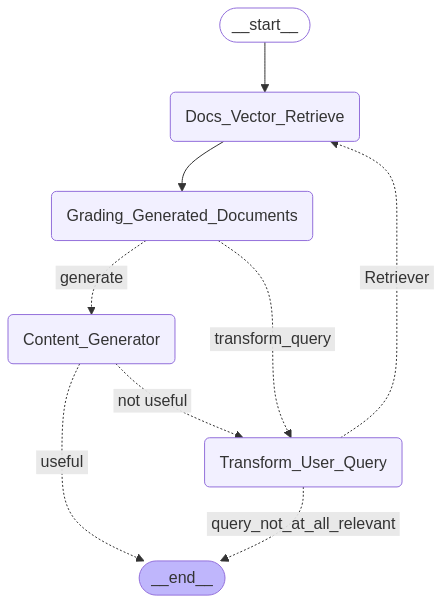

In [13]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("Docs_Vector_Retrieve", retrieve)
workflow.add_node("Grading_Generated_Documents", grade_documents) 
workflow.add_node("Content_Generator", generate)
workflow.add_node("Transform_User_Query", transform_query)


workflow.add_edge(START,"Docs_Vector_Retrieve")
workflow.add_edge("Docs_Vector_Retrieve","Grading_Generated_Documents")
workflow.add_conditional_edges("Grading_Generated_Documents",
                            decide_to_generate,
                            {
                            "generate": "Content_Generator",
                            "transform_query": "Transform_User_Query"
                            }
                            )
workflow.add_conditional_edges("Content_Generator",
                            grade_generation_vs_documents_and_question,
                            {
                            "useful": END,
                            "not useful": "Transform_User_Query",
                            }
                            )
workflow.add_conditional_edges("Transform_User_Query",
                decide_to_generate_after_transformation,
                {
                "Retriever":"Docs_Vector_Retrieve",
                "query_not_at_all_relevant":END
                }
                )


app=workflow.compile()


from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [14]:
inputs = {"question": "Explain how the different types of agent memory work?"}

app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content="Agent memory comes in two primary forms: short-term and long-term. Short-term memory leverages in-context learning, using the model's context window. Long-term memory allows agents to retain and recall information over extended periods, often using an external vector store for fast retrieval.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a5ab13e3-76bf-477f-a318-1d3bf56e0081-0', usage_metadata={'input_tokens': 2072, 'output_tokens': 61, 'total_tokens': 2133, 'input_token_details': {'cache_read': 0}})

In [15]:
inputs = {"question": "who is a prompt engineering?"}
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content='Prompt engineering refers to methods for communicating with large language models to steer their behavior for desired outcomes without updating the model weights. It is an empirical science that requires experimentation and heuristics. The goal of prompt engineering is about alignment and model steerability.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-171b5f20-12b0-463f-9a15-0c077861516f-0', usage_metadata={'input_tokens': 1033, 'output_tokens': 49, 'total_tokens': 1082, 'input_token_details': {'cache_read': 0}})

In [16]:
inputs = {"question": "who is a first president of USA?"}

app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----
this is my document[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text gen

'question was not at all relevant'